### 옷 분리
    
    최초 작성일 : 20/03/09
    작성자 : 양희승
    
    작성내용 : 무신사 이미지를 통해 옷 색깔 판별하기 위한 옷분리 코드

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import argparse
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# 이미지 로드
file_name = "08"
img = cv.imread("img/clothes_test/"+file_name+".jpg")
origin = img

320 250


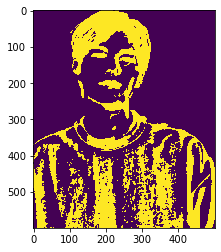

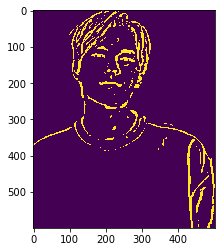

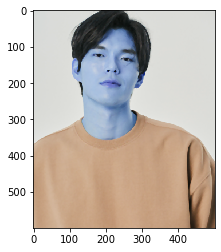

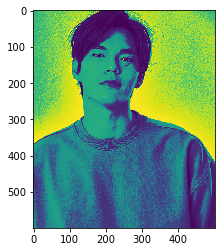

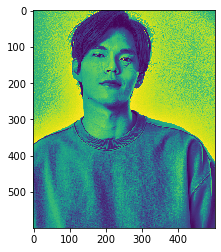

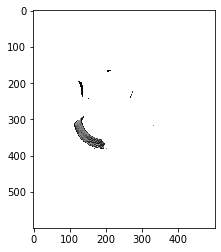

In [2]:
## 대비 강화
file_name = "08"
img = cv.imread("img/clothes_test/"+file_name+".jpg")
gray_img = cv.imread("img/clothes_test/"+file_name+".jpg", 0)
h, w, c = img.shape
h = int(round(h/2, 0))+20
w = int(round(w/2, 0))

print(h, w)

gray_point = gray_img[h][w]


gray = cv.cvtColor(img, cv.COLOR_BGR2LAB)[...,0]
blurred = cv.GaussianBlur(gray, (7, 7), 0)
clahe = cv.createCLAHE(clipLimit=5.0, tileGridSize=(32,32))
contrast = clahe.apply(blurred)



ret, thresh = cv.threshold(contrast, gray_point, 255, cv.THRESH_BINARY_INV)
plt.imshow(thresh)
plt.show()


## 적응 임계처리
thr = cv.adaptiveThreshold(contrast, gray_point, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 15, 20)
plt.imshow(thr)
plt.show()


img_denoise = cv.medianBlur(img, 5)
plt.imshow(img_denoise)
plt.show()



# Equalization
img3 = cv.equalizeHist(gray_img)
plt.imshow(img3)
plt.show()

# CLAHE
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img2 = clahe.apply(img3)
plt.imshow(img2)
plt.show()

# grabcut
img4 = cv.cvtColor(img2, cv.COLOR_GRAY2BGR)
imgo = img4
height, width = imgo.shape[:2]

#Create a mask holder
mask = np.zeros(imgo.shape[:2],np.uint8)

#Grab Cut the object
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

#Hard Coding the Rect… The object must lie within this rect.
rect = (10,10,width-30,height-30)
cv.grabCut(imgo,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
mask = np.where((mask==2)|(mask==0),0,1).astype("uint8")
img1 = imgo*mask[:,:,np.newaxis]

#Get the background
background = imgo-img1

#Change all pixels in the background that are not black to white
background[np.where((background > [0,0,0]).all(axis = 2))] =[255,255,255]

#Add the background and the image
final = background + img1

#To be done – Smoothening the edges….

# plt.imshow("image", final )

plt.imshow(final)
plt.show()



# 임계처리
# img5 = cv.threshold(gray_img,20,,)

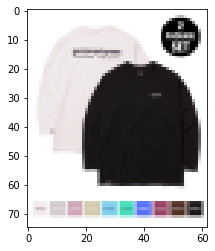

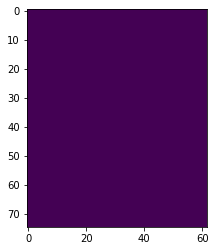

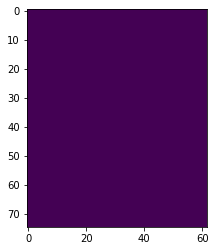

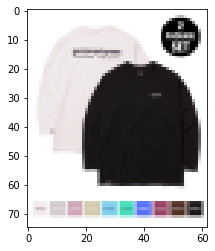

In [5]:
# 배경색 변환
# img=cv2.imread('timg.jpg')
file_name = "07"
img = cv.imread("img/clothes_test/"+file_name+".jpg")

# Scaling
rows,cols,channels = img.shape
img=cv.resize(img,None,fx=0.5,fy=0.5)
rows,cols,channels = img.shape
plt.imshow(img)
plt.show()

# HSV conversion
hsv=cv.cvtColor(img,cv.COLOR_BGR2HSV)
lower_blue=np.array([90,70,70])
upper_blue=np.array([110,255,255])
mask = cv.inRange(hsv, lower_blue, upper_blue)
plt.imshow(mask)
plt.show()

# Corrosion Expansion
erode=cv.erode(mask,None,iterations=1)
cv.imshow('erode',erode)
dilate=cv.dilate(erode,None,iterations=1)
plt.imshow(dilate)
plt.show()

# ergodic substitution
for i in range(rows):
    for j in range(cols):
        if dilate[i,j]==255:
            img [i, j]= (0, 0, 255)# Replace the color here for the BGR channel
plt.imshow(img)
plt.show()

BGR값 :  [ 59  96 164]


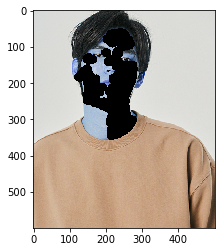

In [34]:
# # 피부색 처리  (혹시 있다면)
# lower = np.array([0, 48, 80], dtype = "uint8")
# upper = np.array([20, 255, 255], dtype = "uint8")

# converted = cv.cvtColor(img, cv.COLOR_BGR2HSV)
# skinMask = cv.inRange(converted, lower, upper)

# kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11,11))
# skinMask = cv.erode(skinMask, kernel, iterations = 2)
# skinMask = cv.dilate(skinMask, kernel, iterations = 2)

# skinMask = cv.GaussianBlur(skinMask, (3,3), 0)
# skin = cv.bitwise_and(img, img, mask = skinMask)

# result = origin - skin
# print("BGR값 : ", result[180][300])
# plt.imshow(result)
# plt.show()


d:\users\yhs\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in ubyte_scalars
d:\users\yhs\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in ubyte_scalars


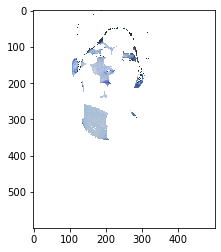

In [35]:
# # 피부 검출2

# hls_img = cv.cvtColor(result, cv.COLOR_BGR2HLS)
# skin_img = hls_img
# temp_img = cv.cvtColor(result, cv.COLOR_BGR2RGB)
# # print("temp_img RGB값 : ", temp_img[180][300])
# h, w, c = hls_img.shape


# for i in range(h) :
#     for j in range(w) :
#         H = hls_img[i][j][0]
#         L = hls_img[i][j][1]
#         S = hls_img[i][j][2]
        
#         R = temp_img[i][j][0]
#         G = temp_img[i][j][1]
#         B = temp_img[i][j][2]
        
#         LS_ratio = L/S
#         skin_pixel = bool((S>=50) and (LS_ratio > 0.5) and (LS_ratio < 3.0) and ((H <= 25) or (H >= 165)))
#         temp_pixel = bool((R == G) and (G == B) and (R >= 220))
                
#         if skin_pixel :
#             if temp_pixel :
#                 skin_img[i][j][0] = 0
#                 skin_img[i][j][1] = 0
#                 skin_img[i][j][2] = 0
#             else :
#                 pass
#         else :
#             skin_img[i][j][0] = 0
#             skin_img[i][j][1] = 0
#             skin_img[i][j][2] = 0
        
        
        

# skin_img = cv.cvtColor(skin_img, cv.COLOR_HLS2BGR)            
# for i in range(h) :
#     for j in range(w) :
#         B = skin_img[i][j][0]
#         G = skin_img[i][j][1]
#         R = skin_img[i][j][2]

#         bg_pixel = bool(B==0 and G==0 and R==0)
        
#         if bg_pixel :
#             skin_img[i][j][0] = 255
#             skin_img[i][j][1] = 255
#             skin_img[i][j][2] = 255
#         else :
#             pass
        


# plt.imshow(skin_img)
# plt.show()

# # cv2.imshow("Original", img)
# # cv2.imshow("Original", skin_img)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()

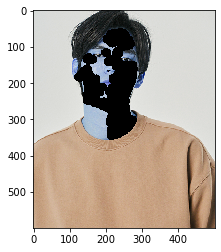

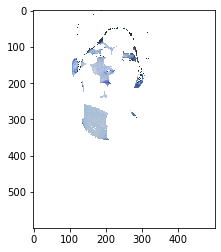

rgb값1 :  [ 59  98 165]
rgb값2 :  [ 59  98 165]


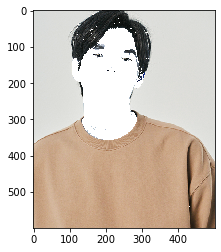

In [41]:
# skin_img1 = cv.cvtColor(result, cv.COLOR_BGR2HLS)
# skin_img1 = cv.cvtColor(skin_img1, cv.COLOR_HLS2BGR)
# skin_img2 = skin_img
# # skin_img2 = cv.cvtColor(skin_img, cv.COLOR_BGR2RGB)
# # remove_skin = result - skin_img2


# plt.imshow(skin_img1)
# plt.show()
# plt.imshow(skin_img)
# plt.show()



# print("rgb값1 : ", skin_img1[180][300])
# print("rgb값2 : ", skin_img2[180][300])

# remove_skin = skin_img1 - skin_img2
# h, w, c = remove_skin.shape

# for i in range(h) :
#     for j in range(w) :
#         test = bool((remove_skin[i][j][0] <= 10) and (remove_skin[i][j][1] <= 10) and (remove_skin[i][j][2] <= 10))
#         if test :
#             remove_skin[i][j][0] = 255
#             remove_skin[i][j][1] = 255
#             remove_skin[i][j][2] = 255

# plt.imshow(remove_skin)
# plt.show()

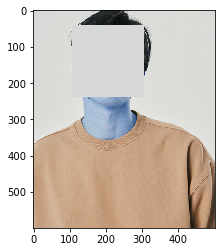

In [82]:
file_name = "08"
img = cv.imread("img/clothes_test/"+file_name+".jpg")
origin = img

faceCascade = cv.CascadeClassifier("data/haarcascade_frontface.xml") 

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
faces = faceCascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(15, 15))

x,y,w,h = 0,0,0,0
if len(faces) > 0: 
    for i in range(len(faces)): 
    # 얼굴 제거
    
else :
    # 경계값 부분
    pass

plt.imshow(img)
plt.show()

In [5]:
# 배경색처리 - 8번 오류
# cv2.namedWindow(‘image’, cv2.WINDOW_NORMAL)

def kim(i) :
    file_name = str(i)
    img = cv.imread("img/clothes_test/"+file_name+".jpg")
    #Load the Image
    imgo = img
    height, width = imgo.shape[:2]

    #Create a mask holder
    mask = np.zeros(imgo.shape[:2],np.uint8)

    #Grab Cut the object
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    #Hard Coding the Rect… The object must lie within this rect.
    rect = (10,10,width-30,height-30)
    cv.grabCut(imgo,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
    mask = np.where((mask==2)|(mask==0),0,1).astype("uint8")
    img1 = imgo*mask[:,:,np.newaxis]

    #Get the background
    background = imgo-img1

    #Change all pixels in the background that are not black to white
    background[np.where((background > [0,0,0]).all(axis = 2))] = [255,255,255]

    #Add the background and the image
    final = background + img1

    #To be done – Smoothening the edges….

    # plt.imshow("image", final )
    cv.imwrite("img/clothes_test/ext_"+file_name+".jpg", final)
#     plt.imshow(final)
#     plt.show()

for i in range(31) :
    kim(i)

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]
68 contours detected


NameError: name 'ROI' is not defined

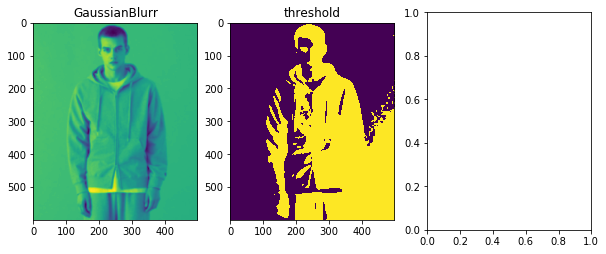

In [28]:
file_name = "01"
img = cv.imread("img/clothes_test/"+file_name+".jpg", 0) # import image as grayscale array

# threshold image
img_b = cv.GaussianBlur(img, (13, 13), 2)
# plt.imshow(img_b)

ret, img_th = cv.threshold(img_b, 160, 255, cv.THRESH_BINARY_INV)
print(img_th)

# find contours
cnts, hierachy = cv.findContours(img_th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
print(str(len(cnts))+' contours detected')

# find maximum area contour
area = np.array([cv.contourArea(cnts[i]) for i in range(len(cnts))]) # list of all areas
maxa_ind = np.argmax(area) # index of maximum area contour

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(img_b)
plt.title('GaussianBlurr')
plt.subplot(1,3,2)
plt.imshow(img_th)
plt.title('threshold')
plt.subplot(1,3,3)
xx = [cnts[maxa_ind][i][0][0] for i in range(len(cnts[maxa_ind]))]
yy = [cnts[maxa_ind][i][0][1] for i in range(len(cnts[maxa_ind]))]
ROI.append([min(xx),max(xx),min(yy),max(yy)])
plt.imshow(img)
plt.plot(xx,yy,'r',linewidth=3)
plt.title('largest contour')

<function matplotlib.pyplot.show(*args, **kw)>

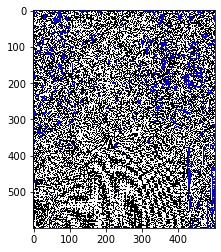

In [3]:
#Read the image and conver to grayscale
file_name = "08"
img = cv.imread("img/clothes_test/"+file_name+".jpg", 0) # import image as grayscale array

#Applt the median filter on the image 
#med = cv2.medianBlur(image,5)    # 5 is a fairly small kernel size
#Apply an edge detection filter 

laplacian = cv.Laplacian(img,cv.CV_64F)

laplacian = laplacian.astype(np.uint8)
ret,thresh1 = cv.threshold(laplacian,127,255,cv.THRESH_BINARY)
src = thresh1
src  = np.array(src, np.uint8)
ret, thresh = cv.threshold(src,10,255,cv.THRESH_BINARY)
# You need to choose 4 or 8 for connectivity type
connectivity =8
# Perform the operation
output = cv.connectedComponentsWithStats(thresh, connectivity, cv.CV_32S)
# Get the results
# The first cell is the number of labels
num_labels = output[0]
# The second cell is the label matrix
labels = output[1]
# The third cell is the stat matrix
stats = output[2]
# The fourth cell is the centroid matrix
centroids = output[3]
src = cv.cvtColor(src,cv.COLOR_GRAY2RGB)
for stat in stats:
    x , y ,w , h ,a = stat
    cv.rectangle(src,(x,y),(x+w,y+h),(0,0,255),2)
    # write original image with added contours to disk
    #cv2.imwrite('contoured.jpg', image)
plt.imshow(src)
plt.show

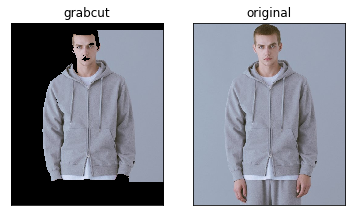

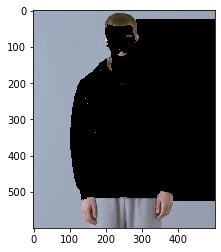

In [11]:


img = cv.imread('img/clothes_test/01.jpg')
OLD_IMG = img.copy()
mask = np.zeros(img.shape[:2], np.uint8)

SIZE = (1, 65)
bgdModle = np.zeros(SIZE, np.float64)
fgdModle = np.zeros(SIZE, np.float64)

rect = (60, 25, 500, 500)

cv.grabCut(img, mask, rect, bgdModle, fgdModle, 5, cv.GC_INIT_WITH_RECT)

mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
img *= mask2[:, :, np.newaxis]

plt.subplot(121)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
cutcut = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.title("grabcut"), plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(cv.cvtColor(OLD_IMG, cv.COLOR_BGR2RGB))

oriori = cv.cvtColor(OLD_IMG, cv.COLOR_BGR2RGB)
plt.title("original"), plt.xticks([]), plt.yticks([])


# plt.savefig('GrabCut.png')
plt.show()

result = oriori - cutcut
plt.imshow(result)
plt.show()

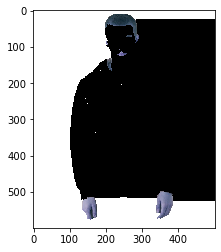

In [12]:
# 배경색처리 - 8번 오류
# cv2.namedWindow(‘image’, cv2.WINDOW_NORMAL)


# img = cv.imread("img/clothes_test/10.jpg")

imgo = cv.cvtColor(result, cv.COLOR_RGB2BGR)
height, width = imgo.shape[:2]

#Create a mask holder
mask = np.zeros(imgo.shape[:2],np.uint8)

#Grab Cut the object
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

#Hard Coding the Rect… The object must lie within this rect.
rect = (10,10,width-30,height-30)
cv.grabCut(imgo,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
mask = np.where((mask==2)|(mask==0),0,1).astype("uint8")
img1 = imgo*mask[:,:,np.newaxis]

#Get the background
background = imgo-img1

#Change all pixels in the background that are not black to white
background[np.where((background > [0,0,0]).all(axis = 2))] =[255,255,255]

#Add the background and the image
final = background + img1

#To be done – Smoothening the edges….

# plt.imshow("image", final )

plt.imshow(final)
plt.show()

# k = cv.waitKey(0)

# if k==27:
#     cv.destroyAllWindows()